Hourly Serial Dataframe Table:
                        voltage   current     power    energy  frequency        pf
time                                                                              
2023-03-24 10:00:00  229.855238  0.013501  1.774023  0.010148  49.975863  0.218998
2023-03-24 11:00:00  231.853554  0.004110  0.553620  0.011000  49.984601  0.063037
2023-03-24 12:00:00  230.269217  0.008161  1.089821  0.011022  49.972320  0.125431
2023-03-24 13:00:00  227.578949  0.008026  1.074548  0.012197  49.974352  0.125475
2023-03-24 14:00:00  225.894417  0.002305  0.303974  0.013000  49.982463  0.034805
2023-03-24 15:00:00  227.575731  0.003128  0.416322  0.013000  49.981938  0.047593
2023-03-24 16:00:00  229.204729  0.010239  1.355731  0.013605  49.999967  0.155445
2023-03-24 17:00:00  231.931461  0.018212  2.349228  0.014570  49.992118  0.284305
2023-03-24 18:00:00  233.829946  0.033776  4.405713  0.018483  49.988803  0.558150
2023-03-24 19:00:00  230.947808  0.023516  3.141534  0.0

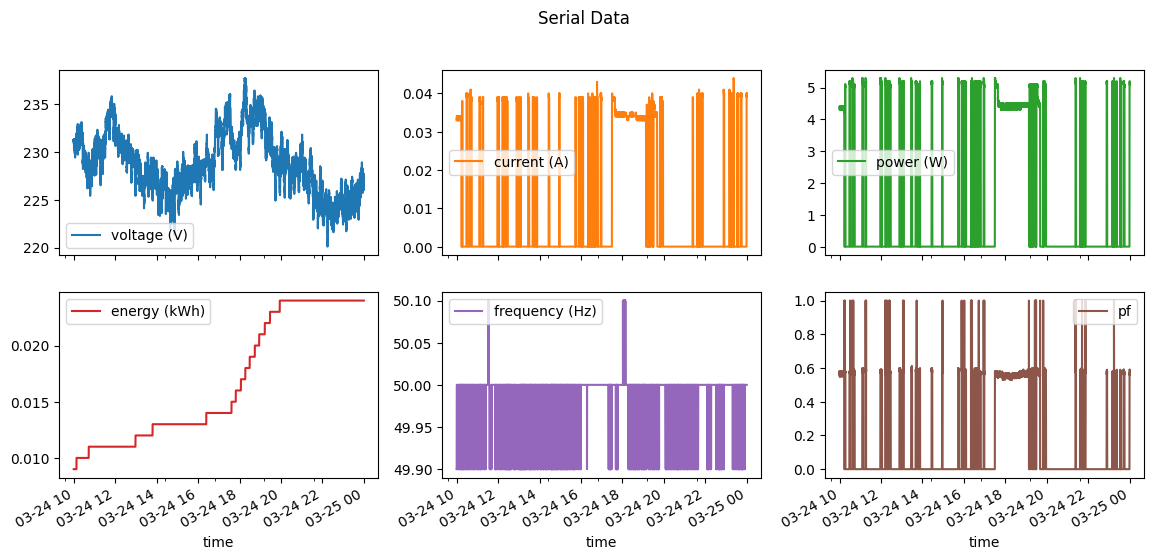

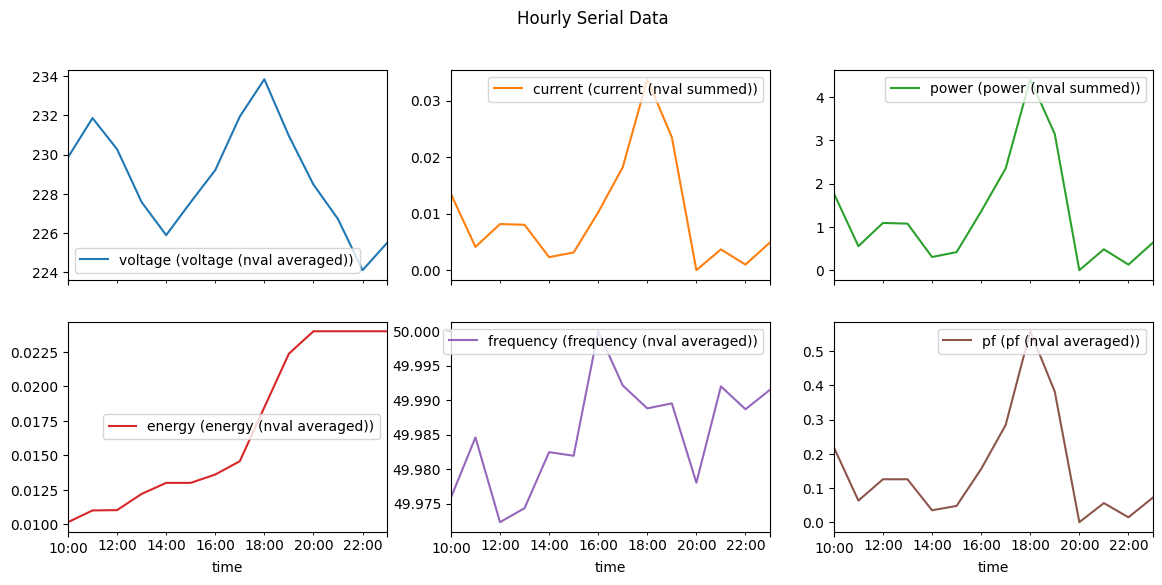

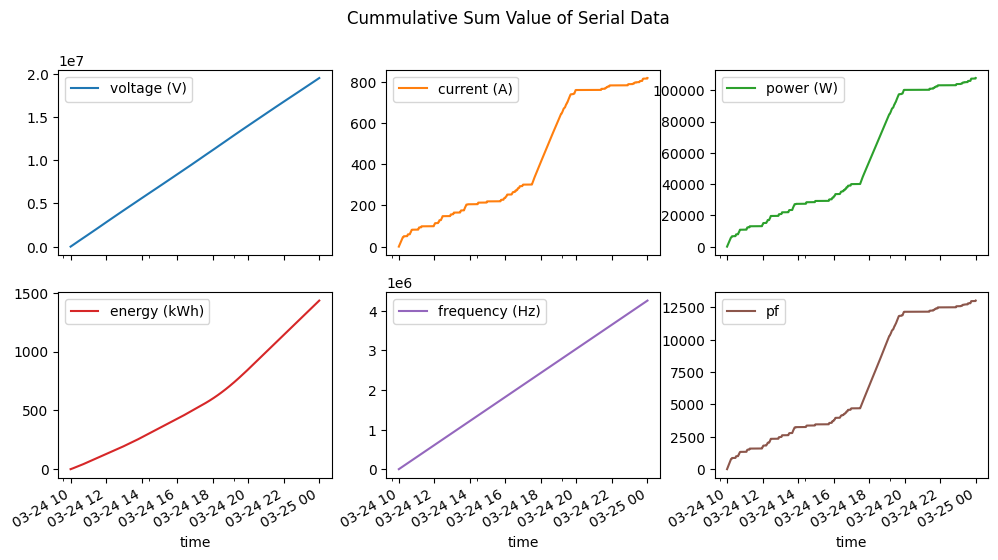

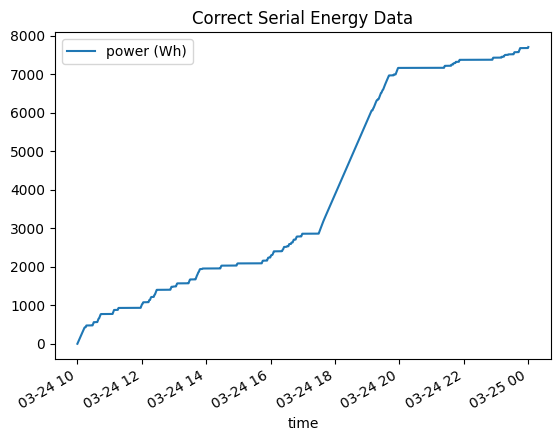

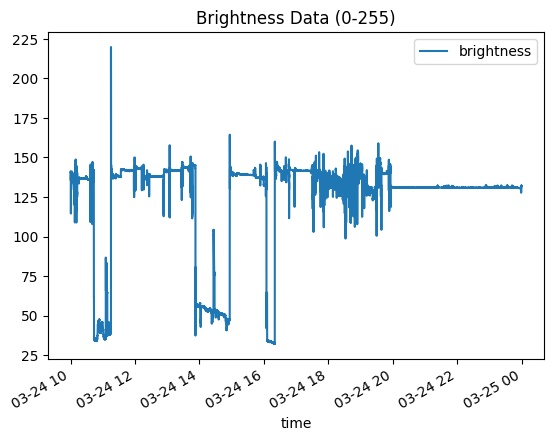

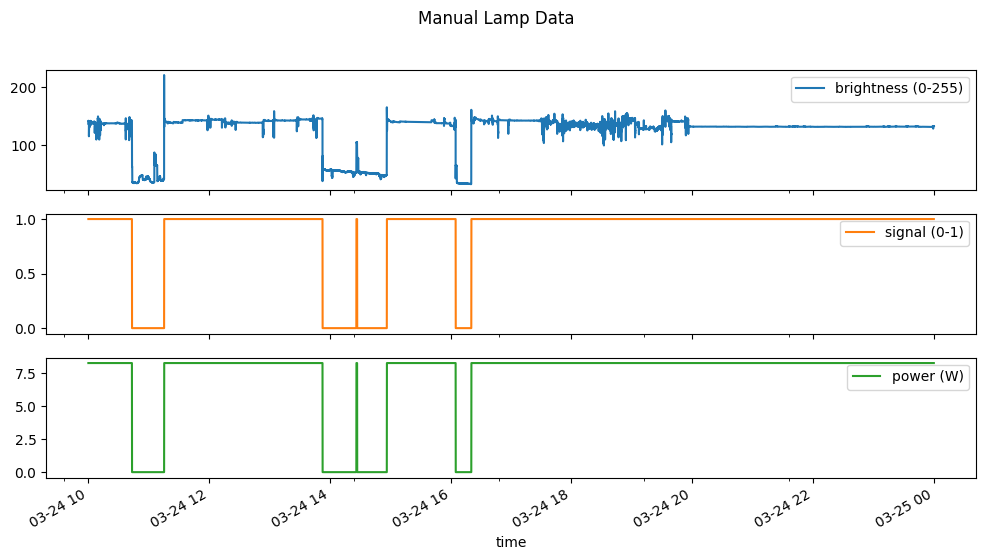

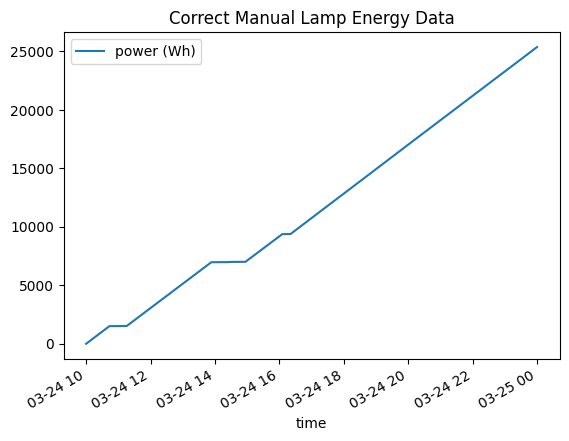

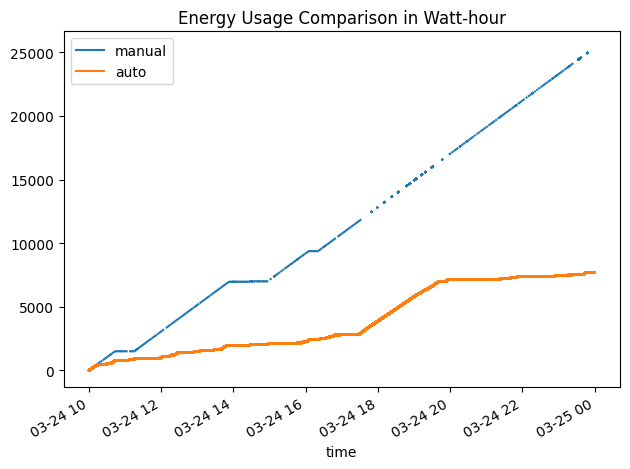

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Callable, Optional

START_TIME = '2023-03-24 10:00:00'
END_TIME = '2023-03-25 00:00:00'

def set_axes_unit(axes: plt.Axes, unit: str):
    text = axes.get_legend().get_texts()[0]
    text_value = text.get_text()
    text.set_text(f'{text_value} ({unit})')

def set_axes2d_unit(axes: np.ndarray[np.ndarray[plt.Axes]], f: Callable[[str], Optional[str]]):
    for ax0 in axes:
        for ax1 in ax0:
            legend = ax1.get_legend()
            texts = legend.get_texts()
            text_value = texts[0].get_text()
            unit = f(text_value)
            if unit is None:
                return
            texts[0].set_text(f'{text_value} ({unit})')

def set_axes1d_unit(axes: np.ndarray[np.ndarray[plt.Axes]], f: Callable[[str], Optional[str]]):
    for ax1 in axes:
        legend = ax1.get_legend()
        texts = legend.get_texts()
        text_value = texts[0].get_text()
        unit = f(text_value)
        if unit is None:
            return
        texts[0].set_text(f'{text_value} ({unit})')


serial_data = pd.read_csv('../24-03-2023/serial_data.csv', index_col='time', parse_dates=True)
serial_data[['voltage', 'current', 'power', 'energy', 'frequency', 'pf']] = serial_data[['voltage', 'current', 'power', 'energy', 'frequency', 'pf']].apply(pd.to_numeric)
serial_data_time_mask = (serial_data.index >= START_TIME) & (serial_data.index <= END_TIME)
serial_data = serial_data[serial_data_time_mask]

duration = (serial_data.index.max()-serial_data.index.min()).total_seconds()

agg_func = {col: 'mean' if col == 'voltage' or col == 'frequency' or col == 'pf' or 'energy' else 'sum' for col in serial_data.columns}
hourly_data = serial_data.resample('H').agg(agg_func)

ax_sd = serial_data.plot(subplots=True, layout=(2, 3), figsize=(14,6), title='Serial Data')
ax_s_data = hourly_data.plot(subplots=True, layout=(2, 3), figsize=(14,6), title='Hourly Serial Data')

# note that the cummulative power data shown may be interpreted as energy,
# however it is not yet in Watt-hour unit at this stage.
ax_sd_cs = serial_data.cumsum().plot(subplots=True, layout=(2, 3), figsize=(12,6), title='Cummulative Sum Value of Serial Data') 

# correct serial data energy
sd_c_e = pd.DataFrame(serial_data['power'].cumsum()/duration*3600)
ax_sd_c_e = sd_c_e.plot(title='Correct Serial Energy Data')


# prevent Dataframe output wrapping
pd.set_option('display.width', 1000)

# printing out tables
print(f"Hourly Serial Dataframe Table:\n{hourly_data}\n")

average_value_non_zero = serial_data.apply(lambda x: x[x != 0].mean())
print(f"Average Value of Non Zero Values from Serial Data:\n{average_value_non_zero}")


# == brightness data processing ==
brightness_data = pd.read_csv('../24-03-2023/brightness_data.csv', index_col='time', parse_dates=True)
brightness_data['brightness'] = brightness_data['brightness'].apply(pd.to_numeric)
brightness_data_time_mask = (brightness_data.index >= START_TIME) & (brightness_data.index <= END_TIME)
brightness_data = brightness_data[brightness_data_time_mask]

brightness_data.plot(title='Brightness Data (0-255)')

# on/off data
brightness_data['signal'] = brightness_data['brightness'].apply(lambda x: 1 if x >= 90 else 0)

# power data
avg_nz_v = average_value_non_zero['voltage']
avg_nz_a = average_value_non_zero['current']
brightness_data['power'] = brightness_data['signal'].apply(lambda x: x * avg_nz_v * avg_nz_a)

# plotting brightness data
ax_ml_data = brightness_data.plot(subplots=True, figsize=(12,6), title='Manual Lamp Data')

# correct manual lamp energy data
ml_c_e = pd.DataFrame(brightness_data['power'].cumsum()/duration*3600)
ax_ml_c_e = ml_c_e.plot(title='Correct Manual Lamp Energy Data')



# compare both correct energy data
# comp = pd.DataFrame()
# comp['manual'] = ml_c_e['power']
# comp['auto'] = sd_c_e['power']
# comp = pd.concat([sd_c_e, ml_c_e], axis=1)
comp = pd.DataFrame({'manual': ml_c_e['power'], 'auto': sd_c_e['power']})
comp.plot(title='Energy Usage Comparison in Watt-hour')


# printing out energy usages
print(f"\nTotal Energy Usage with Sensor: {comp['auto'].max()} Wh")
print(f"Total Energy Usage without Sensor: {comp['manual'].max()} Wh")


# add units
def s_data_legend_unit(text: str) -> Optional[str]:
    match text:
        case 'voltage': return 'V'
        case 'current': return 'A'
        case 'power': return 'W'
        case 'energy': return 'kWh'
        case 'frequency': return 'Hz'
        case 'pf': return None
set_axes2d_unit(ax_sd, s_data_legend_unit)
set_axes2d_unit(ax_sd_cs, s_data_legend_unit)
def hourly_s_data_legend_text(text_value: str) -> str:
    if text_value == 'voltage' or text_value == 'frequency' or text_value == 'pf' or text_value == 'energy':
        return text_value + ' (nval averaged)'
    else:
        return text_value + ' (nval summed)'
set_axes2d_unit(ax_s_data, hourly_s_data_legend_text)
set_axes_unit(ax_sd_c_e, 'Wh')

def ml_data_legend_unit(text: str) -> str:
    match text:
        case 'brightness': return '0-255'
        case 'signal': return '0-1'
        case 'power': return 'W'
set_axes1d_unit(ax_ml_data, ml_data_legend_unit)
set_axes_unit(ax_ml_c_e, 'Wh')


plt.tight_layout()
plt.show()